# RSM 2307 Advanced Derivatives

Assignment 1

In [1]:
import matplotlib.pyplot as plt
from derivatives_pricing.securities.derivatives import *
import derivatives_pricing.sim.wiener as wiener
from portfolio_optimizer.port import *
from portfolio_optimizer.load_data import *
import pandas as pd
import math
import os
import pandas as pd
from pandas.tseries.offsets import *
hm = os.getcwd()
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

# Part 2

# Question 1 Part 2

### Preprocessing the data:

The format_data() function pre process the excel spreadsheet to build the matrix X and the vector y that will be used to solve the minimization of the parameters a,b and c, encoded on the vector w.

## Descriptive statistics

In [2]:
def format_data(dataset,norm=0):
      

    dataset['deltaf'] = dataset['n_midmarket']-dataset['midmarket']

    dataset['deltaS'] = dataset['n_spx']-dataset['spx_level']
    
    dataset['y'] = dataset['deltaf']-np.multiply(dataset['delta'],dataset['deltaS'])
    
    h_1= np.multiply(dataset['vega'],dataset['deltaS'])
    
    h_2 = np.multiply(np.sqrt(dataset['lifeopt']),dataset['spx_level'])
    
    dataset['A1'] = np.divide(h_1,h_2)
    
    dataset['A2'] = np.multiply(dataset['A1'],dataset['delta'])
    
    dataset['A3'] = np.multiply(dataset['A1'],dataset['delta']**2)
    
    '''A4,A5 and A6 are factors that we choose to control for in order
    to improve the model (used only in Question 4)'''
    
    dataset['A4'] =  dataset['spx_level']*dataset['deltaS'] 
    
    dataset['A5'] = (dataset['deltaS']**2)/dataset['spx_level']
    
    dataset['A6'] =  ((dataset['deltaf'])*dataset['deltaS'])/dataset['midmarket']
    
    dataset['bucket'] = [round(i,1) for i in dataset['delta']]
    
    dataset['date1'] = pd.to_datetime(dataset['date1'],format='%Y%m%d', errors='ignore')
    
    dataset.index = pd.to_datetime(dataset['date1'],format='%Y%m%d',errors='ignore')
    
    return dataset

In [3]:
dataset = pd.read_csv(hm+'/data_op.csv')
dataset = format_data(dataset)

### 1) SPX:

In [4]:
dataset['spx_level'].describe()

count    1.002020e+06
mean     1.553888e+03
std      3.912582e+02
min      6.765300e+02
25%      1.239200e+03
50%      1.461190e+03
75%      1.969950e+03
max      2.130820e+03
Name: spx_level, dtype: float64

### 2) Strike prince:

In [5]:
(1/1000)*dataset['strike_price'].describe()

count    1002.020000
mean     1483.621140
std       418.813883
min        50.000000
25%      1175.000000
50%      1450.000000
75%      1840.000000
max      3500.000000
Name: strike_price, dtype: float64

### 3) Implied volatility:

In [6]:
dataset['impl_volatility'].describe()

count    1.002020e+06
mean     2.087461e-01
std      8.629869e-02
min      4.156000e-02
25%      1.473900e-01
50%      1.923300e-01
75%      2.487500e-01
max      1.300780e+00
Name: impl_volatility, dtype: float64

### 4) Extra: frequency table of delta buckets

Calls

In [7]:
dataset[dataset['IsCall']==1]['bucket'].value_counts()

0.9    138301
0.8     72352
0.7     53553
0.1     50984
0.6     44021
0.5     38031
0.2     37215
0.4     34834
0.3     34249
Name: bucket, dtype: int64

Puts

In [8]:
dataset[dataset['IsCall']==0]['bucket'].value_counts()

-0.1    124633
-0.2     69904
-0.9     62643
-0.3     52612
-0.4     43143
-0.8     38761
-0.5     37389
-0.7     34702
-0.6     34693
Name: bucket, dtype: int64

# Question 2 - Part 2
### these are the results we are attempting to replicate (Hull)

The equation $\Delta f - \delta_BS \Delta  = \frac{r}{\sqrt{T}}\frac{\Delta S}{S} (a+b\delta_BS+c\delta_{BS}^2)$ can be re-arranged to fit a common LS model:

\begin{equation}
argmin_w: \frac{1}{2}(y-Ax)^2
\end{equation}

This minimization problem can be solved by making the gradient of this equation equal to zero and finding the solution for w that minimizes the squared error. 

First we defined a constant $h=\frac{r}{\sqrt{T}}\frac{\Delta S}{S}$. Second, we defined a vector $y$ as the BS error and takes the form $y = \Delta f - \delta_BS \Delta_BS$. 

The matrix A will be composed of three columns:

-  A1 is the constant $h$, 
-  A2 is $h\delta_{BS}$ and column 
-  A3 is $h\delta_{BC}^2$

The solution of this equation is presented further on this notebook and implemented on the class OLS(). The format_data() function builds these columns. We also had to implement a function to execute the rolling window procedure.

### The Hedging class:
This class is used to calculate deltaMV and the SSE for both models. The main input are the parameters [a,b,c] 

In [9]:
'''calculate deltaVM and SSE/GAIN from the optimized parameters'''
class hedging:
    def __init__(self):
        self.data = pd.DataFrame([])
        
    def get_deltaMV(self,predicted,deltaS,delta):
        '''calculates deltaMV from the vector w: [a,b,c]'''
        cache = np.divide(predicted,deltaS)     
        dMV = delta + cache
        self.deltaMV = dMV
        pass
    
    def cache(self,newdata):
        '''stores deltaMV and built dataset'''
        newdata['deltaMV'] = self.deltaMV
        self.data = self.data.append(newdata)
        pass
    
    def get_GAIN(self):
        '''calculates squared errors and gain'''
        self.data['SE'] = (self.data['deltaf'] - np.multiply(self.data['deltaMV'],self.data['deltaS']))**2
        self.data['SE_BS'] = self.data['y']**2
        self.GAIN = 1-(self.data['SE'].sum())/self.data['SE_BS'].sum()
        

### Least Square - Solving for w = [a,b,c]
The w that minimizes the least square problem is:
\\( w = (X^TX)^{-1}X^Ty \\) .Where the vector w is the parameter vectors.


In [10]:
'''OLS class solves a linear minimization problem of the form arg_min mean((y-Xw)**2)'''
class OLS:
    def __init__(self):
        self.W = pd.DataFrame([])
    def solve(self,X,y):
        '''solves basic LS problem'''
        XtXinv = np.linalg.inv(np.matmul(X.T,X))      
        self.w = np.matmul(np.matmul(XtXinv,X.T),y)
        return self.w
    def predict(self,X):
        '''Uses optimized w to calculate new y'''
        if len(X.shape)==1:
            X = np.array(X)
            return X.dot(self.w)
        else:
            return np.matmul(X,self.w)
                
    def cache(self,i):
        '''stores vector w: [a,b,c]'''
        self.W = self.W.append(pd.DataFrame.from_dict({i:np.array(self.w)},orient='index'))
        pass
    

### Rolling window OLS
The least square solution is implementd on a rolling window basis. The back parameter is the number of MONTHs used to estimate the vector w, and the forward parameter is the number of days/months evaluated per iteration. The paper considers a roll back of 36 months to estimate the parameters for a month. Here beyond that we have the option to roll back n months and execute the hedging daily, monthly or within any time spam. 

In [11]:
'''Algorithim for slicing the data on a rolling window basis - coupled with OLS and Hedging classes'''
def rolling(d1,back=36,forward=1,unit_forward='monthly',improvements=0):
    '''
    INPUT
    back: number of MONTH's to roll back the window and estimate vector w: [a,b,c]
    forward: number of units to move forward to calculate the squared errors
    unit_forward: unit used, can be monthly or daily
    '''

    if unit_forward=='monthly':
        t0 = d1.index.min()+DateOffset(months=back)
        roll_forward = DateOffset(months=forward)
        roll_backward = DateOffset(months=back)
        dates = pd.date_range(t0,d1.index.max()-roll_forward,freq=roll_forward)
        
    if unit_forward=='daily':
        t0 = d1.index.min()+DateOffset(months=back)
        roll_backward = DateOffset(months=back)
        dates = d1.index[d1.index>t0]
        dates = dates.unique()
        
    if unit_forward =='days':        
        t0 = d1.index.min()+DateOffset(months=back)
        roll_forward = DateOffset(days=forward)
        roll_backward = DateOffset(months=back)      
        dates = pd.date_range(t0,d1.index.max()-roll_forward,freq=roll_forward)
        
    hedge = hedging()
        
        
    if improvements==0:
        
        reg = OLS()
        for i in dates:
                      
            data_window = d1.loc[i-roll_backward:i].copy()     
            A = data_window[['A1','A2','A3']]
            y = data_window['y']
            w = reg.solve(A,y)

            if unit_forward=='daily':
                data_predict = d1.loc[i].copy()
            else:
                data_predict = d1.loc[i:i+roll_forward].copy()       

            A = data_predict[['A1','A2','A3']]
            predicted = reg.predict(A)
            reg.cache(i)

            hedge.get_deltaMV(predicted,data_predict['deltaS'],data_predict['delta'])
            hedge.cache(data_predict)

    if improvements==1:
        
        reg = RidgeR()
        
        for i in dates:
            
            data_window = d1.loc[i-roll_backward:i].copy()     
            A = data_window[['A1','A2','A3','A4','A5','A6']]
            y = data_window['y']
            w = reg.solve(A,y)

            if unit_forward=='daily':
                data_predict = d1.loc[i].copy()
            else:
                data_predict = d1.loc[i:i+roll_forward].copy()       

            A = data_predict[['A1','A2','A3','A4','A5','A6']]
            predicted = reg.predict(A)
            reg.cache(i)

            hedge.get_deltaMV(predicted,data_predict['deltaS'],data_predict['delta'])
            hedge.cache(data_predict)
        
    hedge.get_GAIN()
 
    return reg,hedge.GAIN
    

### Computing the emprical GAIN for call and put options (per delta/bucket)

This are the results from the paper:
<img src="files/hull.png">


This code loops over all buckets/deltas for puts and calls. At each loop a rolling window regression is performed and all regressed coeficients, and the total GAIN, defined as $1-\frac{SSE(error_{mv})}{SSE(error_{BS})}$ are returned. The computations for OLS and for the MV delta are performed on the classes presented previously.

In [12]:
dataset = pd.read_csv(hm+'/data_op.csv')
dataset = format_data(dataset)

In [13]:
np.seterr(divide='ignore', invalid='ignore')
#pd.set_option('mode.chained_assignment', None)

call_table = {}
call_reg = {}

for k in np.arange(0.1,1,0.1):
    d1 = dataset[(dataset['bucket']==round(k,1)) & (dataset['IsCall']==1)].copy()
    reg,GAIN = rolling(d1,back=36,forward=1,unit_forward='monthly')
    call_table[round(k,1)]=GAIN
    call_reg[round(k,1)]=reg

put_table = {}
put_reg = {}
for k in np.arange(0.1,1,0.1):
    d1 = dataset[(dataset['bucket']==-1*round(k,1)) & (dataset['IsCall']==0)].copy()
    reg,GAIN = rolling(d1,back=36,forward=1,unit_forward='monthly')
    put_table[-1*round(k,1)]=GAIN
    put_reg[-1*round(k,1)]=reg
   

### Computing the emprical GAIN for call and put options (all buckets)

In [14]:
d1 = dataset[(dataset['IsCall']==1)].copy()
call_all_reg,call_all_GAIN = rolling(d1,back=36,forward=1,unit_forward='monthly')
d1 = dataset[(dataset['IsCall']==0)].copy()
put_all_reg,put_all_GAIN = rolling(d1,back=36,forward=1,unit_forward='monthly')

### Computed GAINs for CALL options:

In [15]:
pd.DataFrame.from_dict(call_table,orient='index').append(pd.DataFrame.from_dict({'all':call_all_GAIN},orient='index'))

,0
0.1,0.464241
0.2,0.365015
0.3,0.308122
0.4,0.295295
0.5,0.256962
0.6,0.254613
0.7,0.241254
0.8,0.203000
0.9,0.057978
all,0.209473


Estimated GAIN for CALLs

### Computed GAINs for PUT options:

In [16]:
pd.DataFrame.from_dict(put_table,orient='index').append(pd.DataFrame.from_dict({'all':put_all_GAIN},orient='index'))

,0
-0.1,0.224875
-0.2,0.294823
-0.3,0.275153
-0.4,0.242361
-0.5,0.212839
-0.6,0.190945
-0.7,0.183579
-0.8,0.173671
-0.9,0.352728
all,0.240275


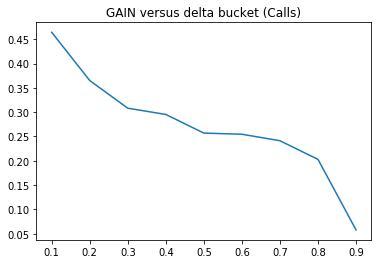

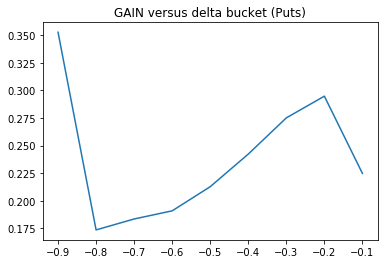

In [17]:
call_plotOLS = pd.DataFrame.from_dict(call_table,orient='index').append(pd.DataFrame.from_dict({'all':call_all_GAIN},orient='index'))
put_plotOLS = pd.DataFrame.from_dict(put_table,orient='index').append(pd.DataFrame.from_dict({'all':put_all_GAIN},orient='index'))
plt.title("GAIN versus delta bucket (Calls)")
plt.plot(call_plotOLS[:-1])
plt.figure()
plt.title("GAIN versus delta bucket (Puts)")
plt.plot(put_plotOLS[:-1])

# Question 3 - Part 2

In [18]:
'''plot coeficients'''
def plot_reg(reg):
    count=1
    plt.figure(figsize=(23,13))
    plt.title("Coefficients a,b and c")
    for k in reg.keys():
        plt.subplot(3,3,count)
        plt.title("delta: {}".format(k))
        plt.plot(reg[k].W/100)
        count +=1
        
'''plot coeficients'''
'''list of regs'''
def plot_all(regs):
    op = ['Call','Put']
    count=1
    plt.figure(figsize=(15,10))
    plt.title("Coefficients a,b and c")
    op_count=0
    for k in regs:
        plt.subplot(2,1,count)
        plt.title('Estimated '+op[op_count]+' Parameters')
        plt.plot(k.W/100)
        count +=1
        op_count +=1

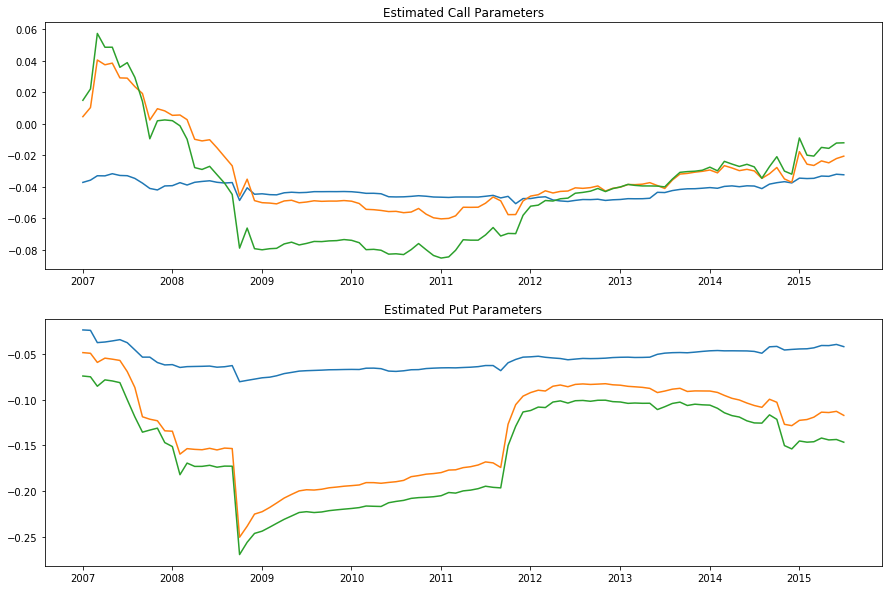

In [19]:
call_all_reg.W[1] *=-1
plot_all([call_all_reg,put_all_reg])

## Coeficients for different deltas/buckets (Calls)

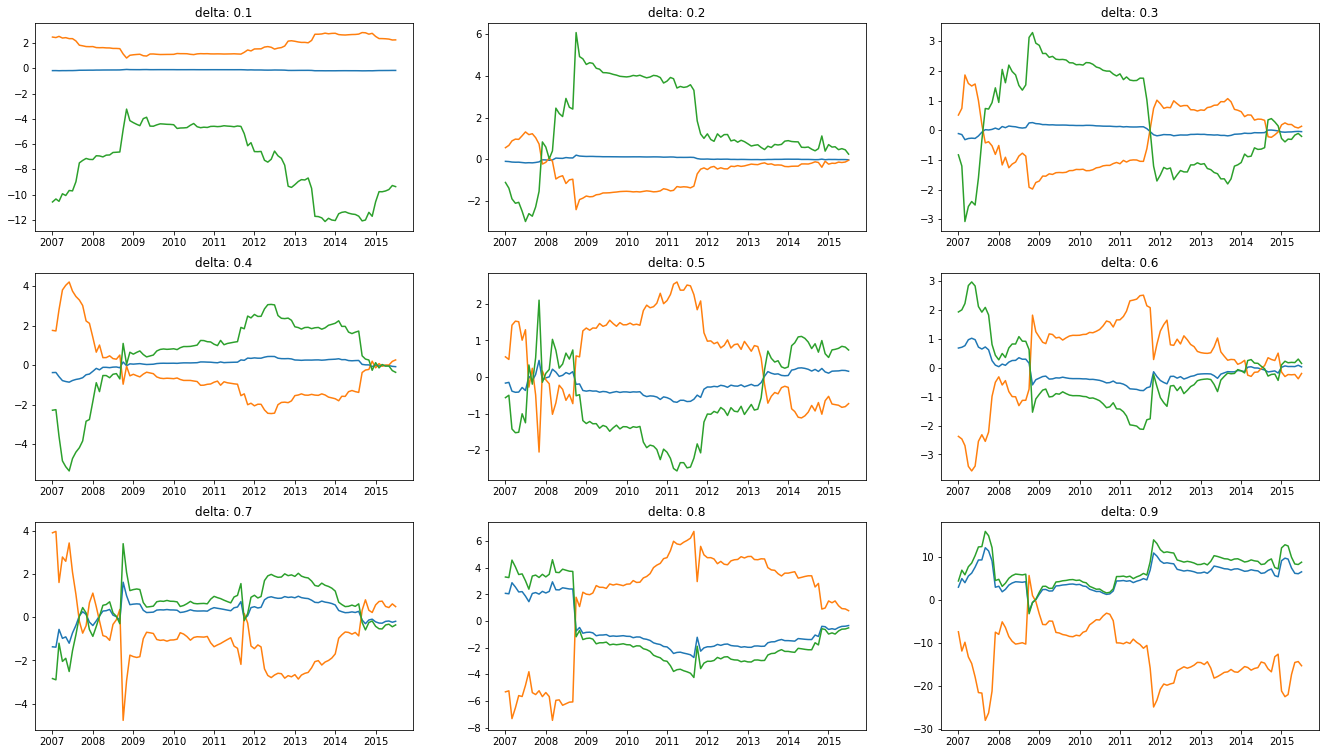

In [20]:
plot_reg(call_reg)

## Coeficients for different deltas/buckets (Puts)

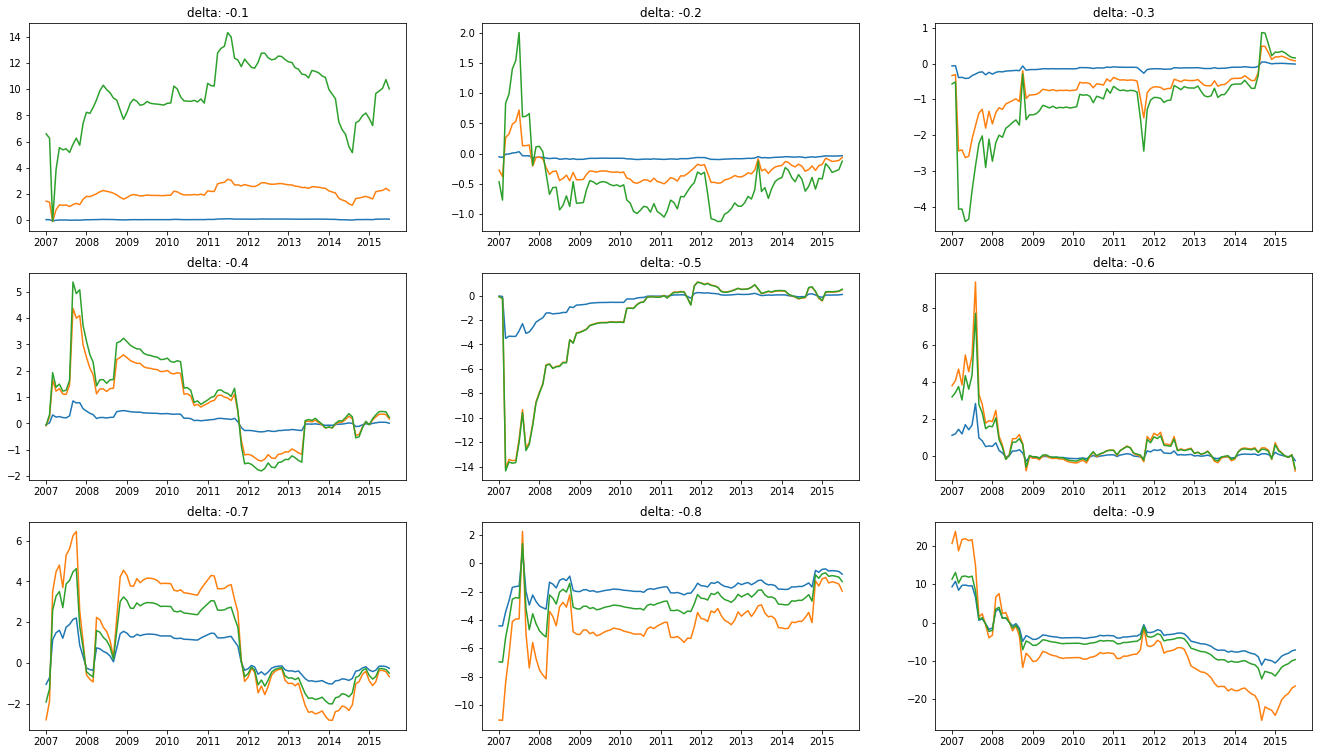

In [21]:
plot_reg(put_reg)

# Question 4 - Part 2

### Controling for additional factors:



Starting from the noise model:

\begin{equation}
\Delta f - \delta_{MV}\Delta S = \epsilon
\end{equation}

We break down the expression for $\delta_{MV}$ and introduce three new factors, adding new columns to the matrix A:

- A4: Fator d, controls for the spx level 
- A5: Factor e, controls for the percent change in the SPX
- A6: Factor f, controls for the percent change in the option price

The "brazuca" modified $\delta_{MV}$ becomes:

\begin{equation}
\delta_{MV}=\delta_{BS}+\frac{\upsilon_{BS}}{S\sqrt{T}}(a+b\delta_{BS}+c\delta^2)+ dS_0 + e\frac{\Delta S}{S_0} + f\frac{\Delta f}{f_0}
\end{equation}

Which leads to:

\begin{equation}
\epsilon_{MV} = \Delta f - \delta_{BS} \Delta S - \frac{\upsilon_{BS}}{\sqrt{T}}\frac{\Delta S}{S} (a+b\delta_{BS}+c\delta_{BS}^2) - d \Delta S S_0 - e\frac{\Delta S^2}{S_0} - f\frac{\Delta S \Delta f}{f_0} 
\end{equation}

The model continues linear with respect to the factors, thus it can be solved using LS as previously. So we take the deltaMV error

\begin{equation}
\epsilon_{MV} = \Delta f - \delta_{MV}\Delta S
\end{equation}
 
adjust the formulation for deltaMV and solve for:
 
 \begin{equation}
 argmin_w: \frac{1}{2}(y-Ax)^2
 \end{equation}
 
 The matrix A will now have six columns:

-  A1 is the constant $h$, 
-  A2 is $h\delta_{BS}$ and column 
-  A3 is $h\delta_{BC}^2$
-  A4 is $S_0$
-  A5 is $\frac{\Delta S}{S_0}$
-  A6 is $\frac{\Delta f}{f_0} $

Finally, the parameter vector is $w = [a,b,c,d,e,f]$ and the vector $y = \Delta f - \delta_BS \Delta_BS$, which is the BS error $\epsilon_{BS}$
 

### Introducing regularization (Ridge Regression)

The least square solution for the linear model we are discussing have a probabilistic interpretation because it leads to the same optimial solution as the maximum likelihood estimate of a normal distribution with mean $Ax$ and standar deviation $\sigma$. We choose to introduce a prior to the model, leading to a Bayesan model whise MLE is the same as the solution of a Ridge Regression. 

\begin{equation}
argmin_w:  (y-Xw)^T(y-Xw) + \lambda X^TX
\end{equation}

And the solution obtained from taking the gradient and making it equal to zero is:

\begin{equation}
w = (X^TX+\lambda I)^{-1}X^Ty
\end{equation}

Because lambda now is a hyper parameter that needs to be choosen we used a k-fold validation procedure with random search at each iteration to select the lambda, using proper validation data, that would generate the minimum error. The 3-fold procedure splits the roll_back data into k folds and alternate the process of training and validating the data using each k split. The results SSE for a set of three trials is recorded for each random parameter. The parameter whose average is the best will be selected to calculate the SSE on the forward data.

We used implementations from SKlearn to minimize coding...

In [22]:
'''Ridge regression with 3 fold algorithim, random search trough the 
range 1e-3 to 1 at intervals of 1e-3'''
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge

class RidgeR():
    def __init__(self):
        self.W = pd.DataFrame([])
    def solve(self,X,y):
        
        reg = Ridge()
        Rcv = RandomizedSearchCV(reg,param_distributions=
                                 {'alpha':np.arange(1e-3,1,5e-3)},
                                n_iter=15)
        Rcv.fit(X,y)
        self.Rcv = Rcv
        self.w = Rcv.best_params_
        
        return self.w
    def predict(self,X):
        
        return self.Rcv.predict(X)
                
    def cache(self,i):
      
        self.W = self.W.append(pd.DataFrame.from_dict({i:np.array(self.w)},orient='index'))
        pass

In [23]:
dataset = pd.read_csv(hm+'/data_op.csv')
dataset = format_data(dataset)

In [24]:
np.seterr(divide='ignore', invalid='ignore')
#pd.set_option('mode.chained_assignment', None)

call_table = {}
call_reg = {}

for k in np.arange(0.1,1,0.1):
    d1 = dataset[(dataset['bucket']==round(k,1)) & (dataset['IsCall']==1)].copy()
    reg,GAIN = rolling(d1,back=36,forward=1,unit_forward='monthly',improvements=1)
    print("bucket: ",k," GAIN: ",GAIN)
    call_table[round(k,1)]=GAIN
    call_reg[round(k,1)]=reg

put_table = {}
put_reg = {}
for k in np.arange(0.1,1,0.1):
    d1 = dataset[(dataset['bucket']==round(-k,1)) & (dataset['IsCall']==0)].copy()
    reg,GAIN = rolling(d1,back=36,forward=1,unit_forward='monthly',improvements=1)
    print("bucket: ",k," GAIN: ",GAIN)
    put_table[round(-k,1)]=GAIN
    put_reg[round(k,1)]=reg
   

bucket:  0.1  GAIN:  0.6007705200098564
bucket:  0.2  GAIN:  0.5161248283844591
bucket:  0.30000000000000004  GAIN:  0.47616373689275704
bucket:  0.4  GAIN:  0.4235799048413077
bucket:  0.5  GAIN:  0.37717026213938953
bucket:  0.6  GAIN:  0.3678460944615638
bucket:  0.7000000000000001  GAIN:  0.3169917142365174
bucket:  0.8  GAIN:  0.2658564004601405
bucket:  0.9  GAIN:  0.10743372789131977
bucket:  0.1  GAIN:  0.375622757017094
bucket:  0.2  GAIN:  0.4310842775225703
bucket:  0.30000000000000004  GAIN:  0.37673262058718804
bucket:  0.4  GAIN:  0.3158929081966565
bucket:  0.5  GAIN:  0.28655965814658524
bucket:  0.6  GAIN:  0.20428209336231762
bucket:  0.7000000000000001  GAIN:  0.19855351572611823
bucket:  0.8  GAIN:  0.13193509576177542
bucket:  0.9  GAIN:  0.32766899098258695


In [25]:
call_plotRR= pd.DataFrame.from_dict(call_table,orient='index').append(pd.DataFrame.from_dict({'all':call_all_GAIN},orient='index'))
put_plotRR = pd.DataFrame.from_dict(put_table,orient='index').append(pd.DataFrame.from_dict({'all':put_all_GAIN},orient='index'))


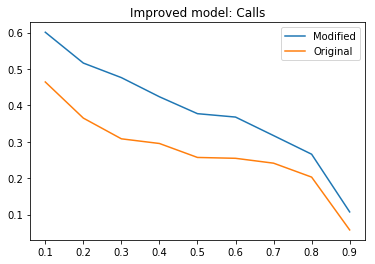

In [26]:
compare_Calls = pd.concat([call_plotRR,call_plotOLS],axis=1)
compare_Calls.columns = ['Modified','Original']
compare_Calls[:-1].plot(x=np.arange(0.1,1,0.1),title='Improved model: Calls')

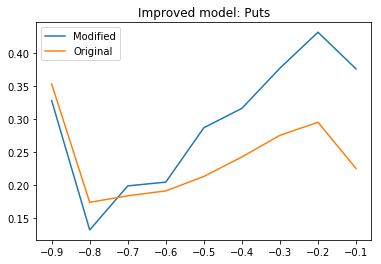

In [27]:
compare_Puts = pd.concat([put_plotRR,put_plotOLS],axis=1)
compare_Puts.columns = ['Modified','Original']
compare_Puts[:-1].plot(x=-1*np.arange(0.1,1,0.1),title='Improved model: Puts')

### Change the rolling window parameter
Next, we perform a test on how the size of the back_roll window affects the GAIN for a call, considering all deltas together. The roll back is varying from 10 to 50 months on an interval of 5 months. The roll forward is varying from 5 to 60 days on an interval of 15 days.

In [28]:
pd.options.mode.chained_assignment = None
np.seterr(divide='ignore', invalid='ignore')
y = np.arange(5,60,15) # forward
x = np.arange(10,50,5) # back
d1 = dataset[(dataset['IsCall']==1)]
summary = {}
for i in x.tolist():
    bin_ = {}
    for j in y.tolist():
        bin_[j] = rolling(d1,back=i,forward=j,unit_forward='daily')
    summary[i]=bin_

In [29]:
r = []
x=[]
y=[]
for i in summary.keys():
    x.append(i)
    bin_=[]
    for j in summary[i].keys():
        y.append(j)
        bin_.append(summary[i][j][1])
    r.append([bin_])
        

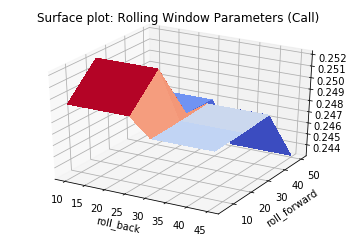

In [30]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array(x)
Y = np.arange(5,60,15)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.reshape(r,(4,8))
plt.title("Surface plot: Rolling Window Parameters (Call)")
plt.xlabel('roll_back')
plt.ylabel('roll_forward')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


The above chart shows that it is possible to obtain a small imporvement in the gain by operating with a roll back between 10 to 25 months and a roll forward of between 10 and 20 days.

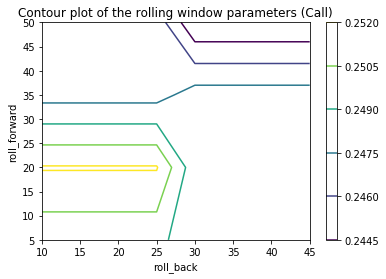

In [31]:
plt.title("Contour plot of the rolling window parameters (Call)")
plt.xlabel('roll_back')
plt.ylabel('roll_forward')
plt.contour(X,Y,Z)
plt.colorbar()

Simulation: influence of the rolling window parameters on the GAIN - calls

### Modified model with changed rolling window's parameters

In [32]:
d1 = dataset[(dataset['IsCall']==1)].copy()
call_all_reg,call_all_GAIN = rolling(d1,back=20,forward=20,unit_forward='days',improvements=1)
d1 = dataset[(dataset['IsCall']==0)].copy()
put_all_reg,put_all_GAIN = rolling(d1,back=20,forward=20,unit_forward='days',improvements=1)

In [33]:
print("Modified model with changed rolling window (call) - GAIN: {}".format(round(call_all_GAIN,2)))
print("Modified model with changed rolling window (put) - GAIN: {}".format(round(put_all_GAIN,2)))

Modified model with changed rolling window (call) - GAIN: 0.33
Modified model with changed rolling window (put) - GAIN: 0.3


In [34]:
np.seterr(divide='ignore', invalid='ignore')
#pd.set_option('mode.chained_assignment', None)

call_table = {}
call_reg = {}

for k in np.arange(0.1,1,0.1):
    d1 = dataset[(dataset['bucket']==round(k,1)) & (dataset['IsCall']==1)].copy()
    reg,GAIN = rolling(d1,back=20,forward=20,unit_forward='days',improvements=1)
    call_table[round(k,1)]=GAIN
    call_reg[round(k,1)]=reg

put_table = {}
put_reg = {}
for k in np.arange(0.1,1,0.1):
    d1 = dataset[(dataset['bucket']==-1*round(k,1)) & (dataset['IsCall']==0)].copy()
    reg,GAIN = rolling(d1,back=20,forward=20,unit_forward='days',improvements=1)
    put_table[-1*round(k,1)]=GAIN
    put_reg[-1*round(k,1)]=reg
   

In [35]:
call_plotRRW= pd.DataFrame.from_dict(call_table,orient='index').append(pd.DataFrame.from_dict({'all':call_all_GAIN},orient='index'))
put_plotRRW = pd.DataFrame.from_dict(put_table,orient='index').append(pd.DataFrame.from_dict({'all':put_all_GAIN},orient='index'))


### Modified MV with 20 months back_window and 20 days forward window.

#### Calls

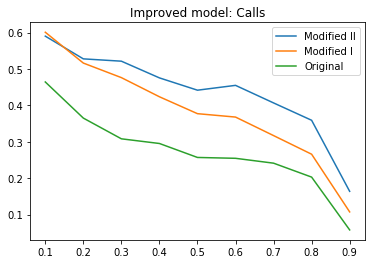

In [36]:
compare_Calls = pd.concat([call_plotRRW,call_plotRR,call_plotOLS],axis=1)
compare_Calls.columns = ['Modified II', 'Modified I','Original']
compare_Calls[:-1].plot(x=np.arange(0.1,1,0.1),title='Improved model: Calls')

#### Puts

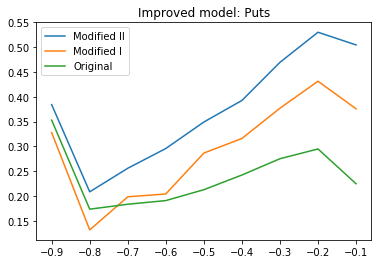

In [39]:
compare_Puts = pd.concat([put_plotRRW,put_plotRR,put_plotOLS],axis=1)
compare_Puts.columns = ['Modified II', 'Modified I','Original']
compare_Puts[:-1].plot(x=-1*np.arange(0.1,1,0.1),title='Improved model: Puts')